<a href="https://colab.research.google.com/github/Lucia1009/TFG-Plataforma-para-la-prediccion-de-potencia-electrica-generada-en-parques-eolicos/blob/desarrollo/modelos/Comparacion_modelos_series_temporales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install openmeteo-requests -q
!pip install requests-cache retry-requests numpy pandas -q

!pip install dash -q

In [2]:
import openmeteo_requests

import requests_cache
import pandas as pd
import numpy as np
from retry_requests import retry

from dash import Dash, html, dcc, Input, Output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error

import sys
import math

rosa='\033[95m'
fin='\033[0m'

# Cargar el histórico

In [3]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2023-01-01",
	"end_date": "2024-12-31",
	"hourly": ["temperature_2m", "wind_speed_10m", "wind_direction_10m"],
	"models": "best_match"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
hourly_wind_direction_10m = hourly.Variables(2).ValuesAsNumpy()


hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}

hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["wind_direction_10m"] = hourly_wind_direction_10m



historico_df = pd.DataFrame(data = hourly_data)


# No hay nan, pero por si acaso
historico_df.dropna(inplace = True)

historico_df['wd_sin_10m'] = np.sin(historico_df['wind_direction_10m']*np.pi/180)
historico_df['wd_cos_10m'] = np.cos(historico_df['wind_direction_10m']*np.pi/180)


historico_df.head()

Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s


,date,temperature_2m,wind_speed_10m,wind_direction_10m,wd_sin_10m,wd_cos_10m
0,2023-01-01 00:00:00+00:00,15.3085,30.532158,232.184204,-0.789986,-0.613125
1,2023-01-01 01:00:00+00:00,15.7085,30.699368,230.710602,-0.773958,-0.633237
2,2023-01-01 02:00:00+00:00,15.7585,31.259941,231.546265,-0.783111,-0.621882
3,2023-01-01 03:00:00+00:00,15.8585,28.394392,230.659500,-0.773392,-0.633928
4,2023-01-01 04:00:00+00:00,15.8085,28.266304,223.451889,-0.687745,-0.725952




---


# Datos de los modelos
Los modelos seleccionados son:

['ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km']

1. *ECMWF IFS 0.4°*
2. *NCEP GFS Global 0.11°/0.25°*
3. *JMA GSM*
4. *DWD ICON Global*
5. *DWD ICON EU*
6. *DWD ICON D2*
7. *GEM Global*
8. *UK Met Office Global 10km*
9. *Météo-France ARPEGE Europe*
10. *Météo-France AROME France HD*




In [4]:
lista_modelos=['best_match','ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km']

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
	"start_date": "2023-01-01",
	"end_date": "2024-12-31",
	"hourly": ["temperature_2m", "wind_speed_10m", "wind_direction_10m"],
	"models": lista_modelos
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
models=dict()
for response, mod in zip(responses, lista_modelos):

  print(f"{rosa}Model {mod}{fin}")  #Imprime con colores
  print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
  print(f"Elevation {response.Elevation()} m asl")
  print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s\n")


  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
  hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
  hourly_wind_direction_10m = hourly.Variables(2).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
  )}

  hourly_data["temperature_2m"] = hourly_temperature_2m
  hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
  hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe.dropna(inplace = True)

  hourly_dataframe['wd_sin_10m'] = np.sin(hourly_dataframe['wind_direction_10m']*np.pi/180)
  hourly_dataframe['wd_cos_10m'] = np.cos(hourly_dataframe['wind_direction_10m']*np.pi/180)

  models[mod]=hourly_dataframe
  print(hourly_dataframe.iloc[0], '\n\n')

print(len(models))
print(models.keys())

Model best_match
Coordinates 52.52000045776367°N 13.419998168945312°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s

date                  2023-01-01 00:00:00+00:00
temperature_2m                        15.945499
wind_speed_10m                        20.390114
wind_direction_10m                   222.137527
wd_sin_10m                            -0.670913
wd_cos_10m                            -0.741536
Name: 0, dtype: object 


Model ecmwf_ifs04
Coordinates 52.40000915527344°N 13.600006103515625°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s

date                  2023-01-01 00:00:00+00:00
temperature_2m                             15.7
wind_speed_10m                        29.671074
wind_direction_10m                   234.381424
wd_sin_10m                            -0.812912
wd_cos_10m                            -0.582386
Name: 0, dtype: object 


Model gfs_global
Coordinates 52.54148864746094°N 13.359375°E
Elevation 38.0 m asl
T

In [5]:
# todos=historico_df.copy()
# for mod in models.keys():
#   todos=todos.merge(models[mod], on="date", how="left", suffixes=("", f"_{mod}"),)

# todos.head(20)




---

# Obtener las métricas de cada modelo

In [6]:
# Obtengo el error de la dirección a través del error del seno y el coseno

def diferencia_angulos(sin_real, cos_real, sin_pagina, cos_pagina):

  producto_escalar = sin_real * sin_pagina + cos_real * cos_pagina
  producto_escalar = max(-1.0, min(1.0, producto_escalar))
  angulo_rad = math.acos(producto_escalar)
  angulo_deg = math.degrees(angulo_rad)
  return angulo_deg



In [7]:
atribs=['temperature_2m', 'wind_speed_10m', 'wd_sin_10m', 'wd_cos_10m']
atributos=['temperature_2m', 'wind_speed_10m']

def obtener_metricas(historico_df, models):

  scores=dict()
  error_angulos=dict()

  for mod in models.keys():

    print(f"\n{rosa}Model {mod}{fin}")
    print(f'maxima direccion', models[mod]['wind_direction_10m'].max())
    print(f'minima direccion', models[mod]['wind_direction_10m'].min())
    scores[mod]=dict()

    hist_df=historico_df.copy()

    for atributo in atributos:

      datos_trabajo_model=hist_df.merge(models[mod], on="date", how="left", suffixes=("", f"_{mod}"),)
      datos_trabajo_model.dropna(inplace=True)

      y_true=datos_trabajo_model[atributo]
      y_pred_model=datos_trabajo_model[atributo+f"_{mod}"]
      rmse = np.sqrt(mean_squared_error(y_true, y_pred_model))
      mae = mean_absolute_error(y_true, y_pred_model)
      r2 = r2_score(y_true, y_pred_model)
      mx_error = max_error(y_true, y_pred_model)


      print(f"{atributo}: rmse: {rmse}, mae: {mae}, r2: {r2}, max_error:{mx_error}")
      scores[mod][atributo]={'rmse':rmse, 'mae':mae, 'r2':r2, 'max_error':mx_error}

      error_angulos[mod]=[diferencia_angulos(datos_trabajo_model['wd_sin_10m'][k], datos_trabajo_model['wd_cos_10m'][k], datos_trabajo_model['wd_sin_10m'+f"_{mod}"][k], datos_trabajo_model['wd_cos_10m'+f"_{mod}"][k]) for k in datos_trabajo_model.index]

  return scores, error_angulos

scores, error_angulos=obtener_metricas(historico_df, models)


Model best_match
maxima direccion 360.0
minima direccion 1.4320632219314575
temperature_2m: rmse: 1.0753085625068393, mae: 0.7936776280403137, r2: 0.9818861484527588, max_error:8.713001251220703
wind_speed_10m: rmse: 4.832111774288624, mae: 4.056494235992432, r2: 0.466105580329895, max_error:19.983684539794922

Model ecmwf_ifs04
maxima direccion 360.0
minima direccion 1.0416086912155151
temperature_2m: rmse: 0.6796604019551079, mae: 0.4823457896709442, r2: 0.9927635192871094, max_error:5.141499996185303
wind_speed_10m: rmse: 2.4100743408133845, mae: 1.7880427837371826, r2: 0.8671864867210388, max_error:19.41615867614746

Model gfs_global
maxima direccion 360.0
minima direccion 0.7440446615219116
temperature_2m: rmse: 1.4579831202384157, mae: 1.0749601125717163, r2: 0.9666996002197266, max_error:8.64999771118164
wind_speed_10m: rmse: 2.743634920596151, mae: 2.0643346309661865, r2: 0.8278789520263672, max_error:20.52653694152832

Model jma_gsm
maxima direccion 360.0
minima direccion 0.8

# Histograma de resultados

<ipython-input-8-ea3cd0e7aeca>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  model_colors = plt.cm.get_cmap('viridis', len(lista_modelos))


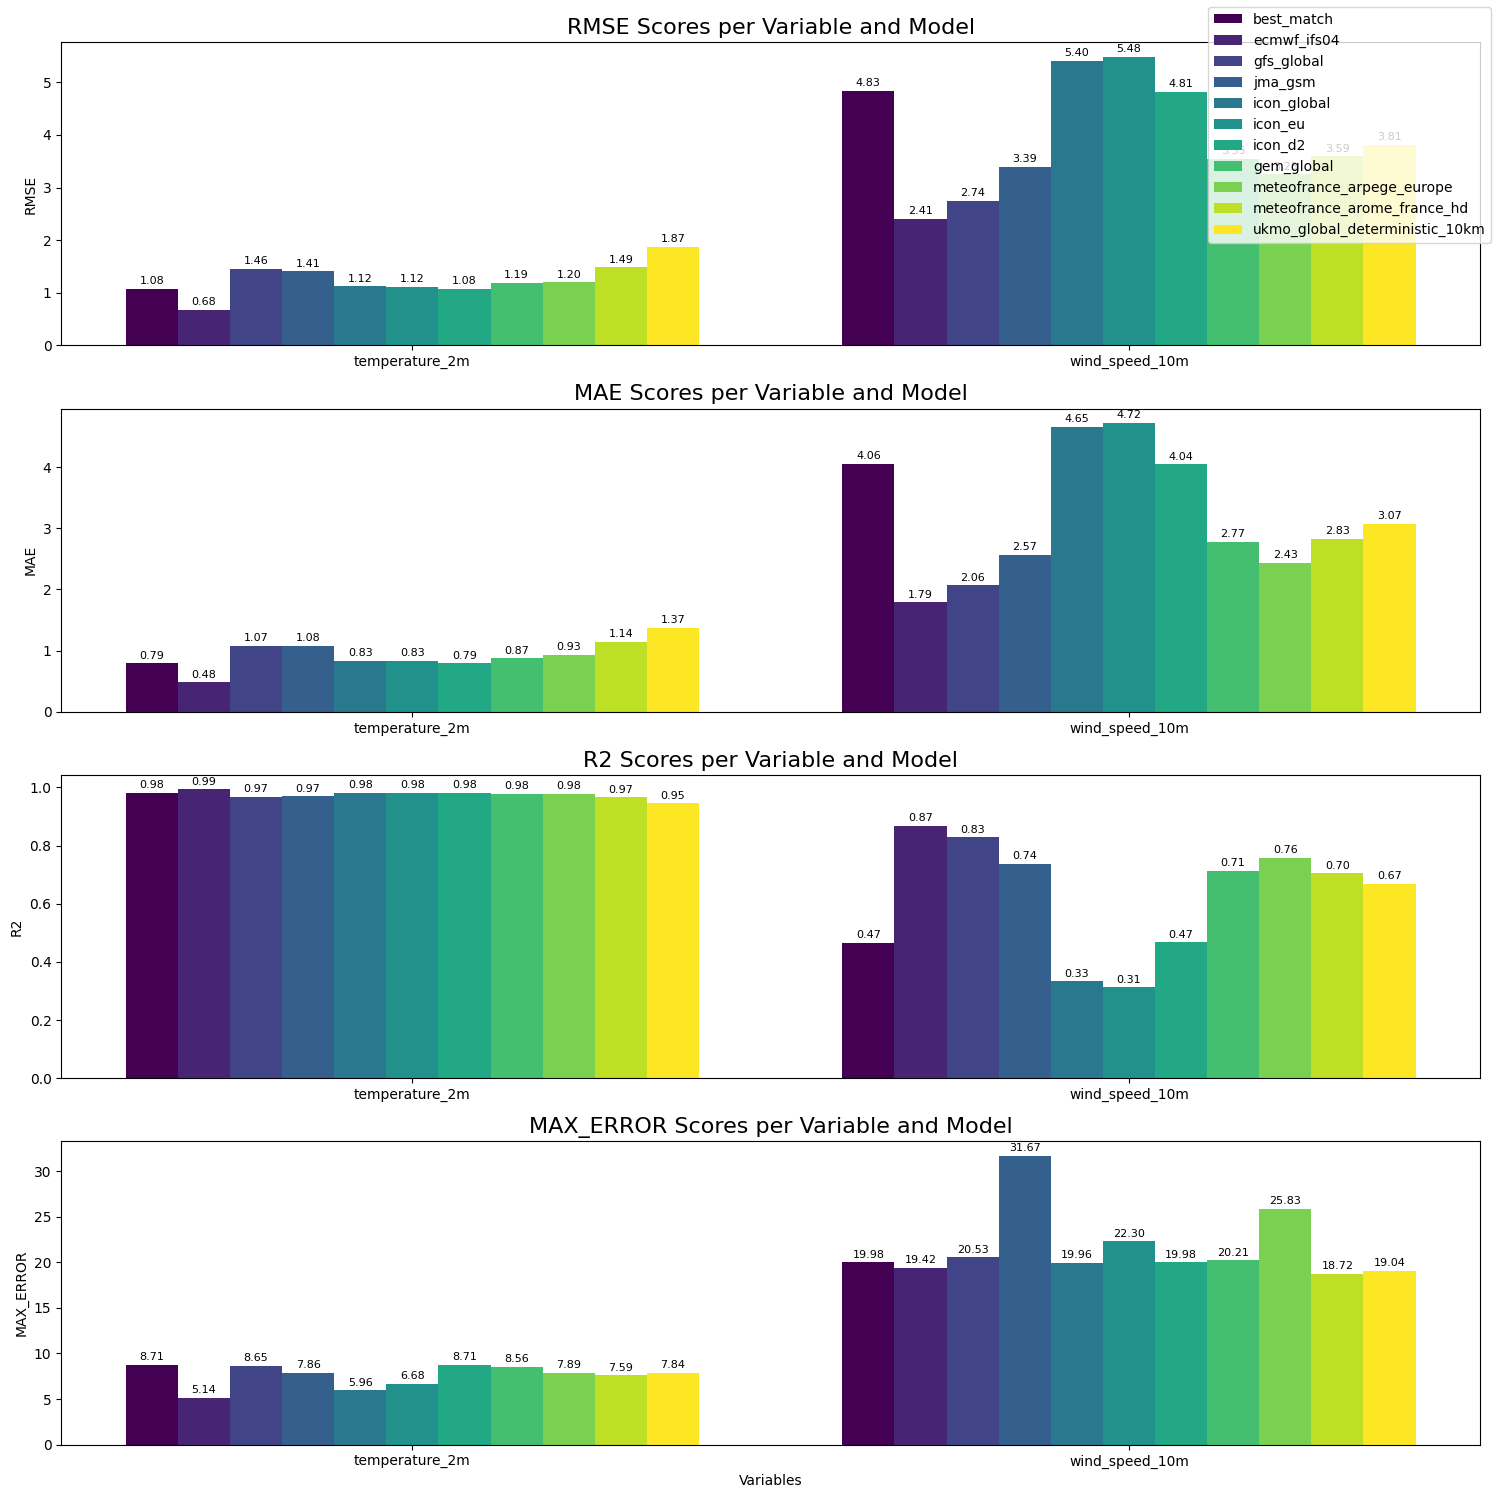

<Figure size 640x480 with 0 Axes>

In [8]:
import matplotlib.pyplot as plt

def graficar_metricas(scores, nombre=None):

  lista_modelos = list(scores.keys())

  # Define colors for each model
  model_colors = plt.cm.get_cmap('viridis', len(lista_modelos))
  model_colors = [model_colors(i) for i in range(len(lista_modelos))]
  model_colors_dict = dict(zip(lista_modelos, model_colors))

  # Define metrics
  metrics = ['rmse', 'mae', 'r2', 'max_error'] # Changed to lowercase

  # Define the bar width and position offset for each model
  bar_width = 0.8 / len(lista_modelos)

  # Calculate the positions for each bar
  def calculate_bar_positions(variable_index, model_index):
      group_center = variable_index
      offset = (model_index - len(lista_modelos) / 2 + 0.5) * bar_width
      return group_center + offset

  # Create the figure and subplots
  fig, axes = plt.subplots(len(metrics), 1, figsize=(15, 15))

  # Loop through each metric and variable, and plot the bars
  for metric_index, metric in enumerate(metrics):
      for variable_index, variable in enumerate(atributos):
          for model_index, model in enumerate(lista_modelos):

              score = scores[model][variable][metric] # Access using metric name
              bar_position = calculate_bar_positions(variable_index, model_index)
              bars = axes[metric_index].bar(bar_position, score, width=bar_width, color=model_colors_dict[model], label=model if variable_index == 0 else "")
              axes[metric_index].bar_label(bars, fmt='%.2f', label_type='edge', padding=2, fontsize=8)

      axes[metric_index].set_ylabel(metric.upper()) # Convert to uppercase for label
      axes[metric_index].set_title(f'{metric.upper()} Scores per Variable and Model', fontsize=16)
      # Set the x-axis labels and ticks for each subplot
      axes[metric_index].set_xticks(range(len(atributos)))
      axes[metric_index].set_xticklabels(atributos)


  # Set the x-axis label for the bottom plot
  axes[-1].set_xlabel("Variables")

  # Add a legend
  handles, labels = axes[0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='upper right')

  # Adjust the layout and display the plot
  plt.tight_layout()
  plt.show()

  # Guardar plot
  if nombre is not None:
    plt.savefig(nombre, dpi=300)

graficar_metricas(scores, 'comparacion_modelos_series_temporales.png')




---
# Comparación 1 hora antes


In [9]:
def obtener_atraso(historico_df, models):

  scores_atraso=dict()
  datos_atraso_dict = {}  # Create a dictionary to store the delayed dataframes
  for mod in models.keys():

    #print(f"\n{rosa}Model {mod}{fin}")
    scores_atraso[mod]=dict()

    hist_df=historico_df.copy()

    for atributo in atributos:
      # Atraso una hora todos los datos del modelo
      datos_atraso=models[mod].copy()
      datos_atraso['date']=datos_atraso['date']-pd.Timedelta(hours=1)
    datos_atraso_dict[mod] = datos_atraso  # Store the delayed dataframe in the dictionary
  return datos_atraso_dict

datos_atraso=obtener_atraso(historico_df, models)
scores_atraso, error_angulos_atraso=obtener_metricas(historico_df, datos_atraso)
#

#       datos_trabajo_1h=hist_df.merge(datos_atraso, on="date", how="left", suffixes=("", f"_{mod}"),)
#       datos_trabajo_1h.dropna(inplace=True)
#       y_true=datos_trabajo_1h[atributo]
#       y_pred_1h=datos_trabajo_1h[atributo+f"_{mod}"]
#       mse = mean_squared_error(y_true, y_pred_1h)
#       mae = mean_absolute_error(y_true, y_pred_1h)
#       r2 = r2_score(y_true, y_pred_1h)

#       print(f"{atributo}: mse: {mse}, mae: {mae}, r2: {r2}")
#       scores_atraso[mod][atributo]={'mse':mse, 'mae':mae, 'r2':r2}

#   return scores_atraso

# scores_atraso=obtener_metricas_atraso(historico_df, models)






Model best_match
maxima direccion 360.0
minima direccion 1.4320632219314575
temperature_2m: rmse: 1.0075914598889764, mae: 0.7590582966804504, r2: 0.9840949773788452, max_error:7.062999725341797
wind_speed_10m: rmse: 4.908905865492294, mae: 4.09719181060791, r2: 0.449012815952301, max_error:21.175579071044922

Model ecmwf_ifs04
maxima direccion 360.0
minima direccion 1.0416086912155151
temperature_2m: rmse: 0.9934356528160295, mae: 0.7247905731201172, r2: 0.984538733959198, max_error:6.508501052856445
wind_speed_10m: rmse: 2.630898252340113, mae: 1.947131633758545, r2: 0.8417366743087769, max_error:17.894214630126953

Model gfs_global
maxima direccion 360.0
minima direccion 0.7440446615219116
temperature_2m: rmse: 1.5791134146751018, mae: 1.1913269758224487, r2: 0.9609346389770508, max_error:8.950000762939453
wind_speed_10m: rmse: 2.9207348562519164, mae: 2.1994199752807617, r2: 0.8049453496932983, max_error:23.515289306640625

Model jma_gsm
maxima direccion 360.0
minima direccion 0.8

In [10]:
verde='\033[92m'  #Mejor con los datos reales del momento
rojo='\033[91m'   #Mejor con los datos del momento anterior

for mod in models.keys():
  print(f"\n\n\n{rosa}Model {mod}{fin}")
  for atributo in atributos:
    print(f"\n{atributo}")
    for metrica in scores_atraso[mod][atributo]: #iteramos por los nombres de las métricas
      resta=scores[mod][atributo][metrica]-scores_atraso[mod][atributo][metrica]
      porcentaje=resta/scores[mod][atributo][metrica]
      if metrica != 'r2' and resta>0 or metrica == 'r2' and resta<0:
         print(f'{rojo}resta {metrica}{fin}', resta, 'porcentaje', porcentaje)
      else:
         print(f'{verde}resta {metrica}{fin}', resta, 'porcentaje', porcentaje)





Model best_match

temperature_2m
resta rmse 0.0677171026178629 porcentaje 0.0629745776970247
resta mae 0.03461933135986328 porcentaje 0.04361888270095581
resta r2 -0.0022088289260864258 porcentaje -0.0022495774378394734
resta max_error 1.6500015 porcentaje 0.18937235

wind_speed_10m
resta rmse -0.07679409120366998 porcentaje -0.015892449262512248
resta mae -0.040697574615478516 porcentaje -0.010032696276103977
resta r2 0.017092764377593994 porcentaje 0.03667144333585594
resta max_error -1.1918945 porcentaje -0.05964338



Model ecmwf_ifs04

temperature_2m
resta rmse -0.3137752508609216 porcentaje -0.46166475192363304
resta mae -0.24244478344917297 porcentaje -0.502636881343089
resta r2 0.008224785327911377 porcentaje 0.00828473767228825
resta max_error -1.367001 porcentaje -0.26587594

wind_speed_10m
resta rmse -0.22082391152672853 porcentaje -0.09162535270683887
resta mae -0.1590888500213623 porcentaje -0.08897373791518075
resta r2 0.025449812412261963 porcentaje 0.0293475657219838

# Cuenta número de datos mejores

In [11]:
def más_error(a, b, c):
  if abs(a-b) > abs(a-c):
    return 1
  else:
    return 0

hist_df=historico_df.copy()

def cuenta_mejores(hist_df, models, datos_atraso):
  cuenta=pd.DataFrame(columns=['Modelo', 'Atributo', 'Cuenta_peor_1h', 'Cuenta_peor_Model', 'Cuenta_iguales'])
  for mod in models.keys():

    for atributo in atributos:
      # Uno los datos del modelo con los datos históricos y borro los nulos
      datos_trabajo_model=hist_df.merge(models[mod], on="date", how="left", suffixes=("", f"_{mod}"),)
      datos_trabajo_model.dropna(inplace=True)

      # Uno a los datos unidos los datos de 1 hora antes y borro los nulos
      datos_trabajo=datos_trabajo_model.merge(datos_atraso[mod], on="date", how="left", suffixes=("", f"_{mod}"),)
      datos_trabajo.dropna(inplace=True)

      # De todos los datos mezclados tomo los valores
      y_true=datos_trabajo[atributo]
      y_pred=datos_trabajo[atributo+f"_{mod}"]
      y_pred_model=y_pred.iloc[:,0]
      y_pred_1h=y_pred.iloc[:,1]

      # Cuento las veces que cada uno es mejor
      cuenta_1h = np.sum(np.fromiter((más_error(y_true.iloc[k], y_pred_1h.iloc[k], y_pred_model.iloc[k]) for k in range(len(y_true))), dtype=float))
      cuenta_model = np.sum(np.fromiter((más_error(y_true.iloc[k], y_pred_model.iloc[k], y_pred_1h.iloc[k]) for k in range(len(y_true))), dtype=float))
      cuenta_iguales=len(y_true)-cuenta_1h-cuenta_model
      cuenta.loc[len(cuenta)] = [mod, atributo, cuenta_1h, cuenta_model, cuenta_iguales]
      # print(len(y_true),cuenta_1h+cuenta_model+cuenta_iguales)
  return cuenta

cuenta=cuenta_mejores(hist_df, models, datos_atraso)
cuenta



,Modelo,Atributo,Cuenta_peor_1h,Cuenta_peor_Model,Cuenta_iguales
0,best_match,temperature_2m,7742.0,9180.0,621.0
1,best_match,wind_speed_10m,8664.0,8592.0,287.0
2,ecmwf_ifs04,temperature_2m,10889.0,6021.0,633.0
3,ecmwf_ifs04,wind_speed_10m,9369.0,7765.0,409.0
4,gfs_global,temperature_2m,8371.0,8204.0,968.0
5,gfs_global,wind_speed_10m,9297.0,7980.0,266.0
6,jma_gsm,temperature_2m,7614.0,9273.0,656.0
7,jma_gsm,wind_speed_10m,8500.0,8244.0,799.0
8,icon_global,temperature_2m,7362.0,9564.0,617.0
9,icon_global,wind_speed_10m,8531.0,8370.0,642.0


In [12]:
"""Gráfica de datos para cada modelo y variable"""

app = Dash('app1')

app.layout = html.Div([

  dcc.Dropdown(lista_modelos, lista_modelos[0], id='modelo', clearable=False),
  dcc.Dropdown(atribs, atribs[0], id='atributo', clearable=False),
  dcc.Checklist(
          id='ver_error',
          options=[{'label': 'Cambiar a visualizar error', 'value': 'error'}],
          value=[]
  ),

  dcc.Graph(id='graph')
])


@app.callback(
    Output('graph', 'figure'),
    Input('modelo', 'value'),
    Input('atributo', 'value'),
    Input('ver_error', 'value'))
def update_output_div(modelo, atributo, ver_error):

  # Crear figura base

  fig = go.Figure()

  datos_trabajo_model=hist_df.merge(models[modelo], on="date", how="left", suffixes=("", f"_{modelo}"),)
  datos_trabajo_model.dropna(inplace=True)

  y_true=datos_trabajo_model[atributo]
  y_pred_model=datos_trabajo_model[atributo+f"_{modelo}"]


  if 'error' in ver_error:
    if atributo != 'wd_sin_10m' and atributo != 'wd_cos_10m':
      fig.add_trace(go.Scatter(y=y_true-y_pred_model, mode='lines', marker=dict(color='red'), name='Error'))
      fig.update_layout(
          title='Error historico vs prediccion',
          transition_duration=10,
          xaxis_title='tiempo (h)',
          yaxis_title=f'Error{atributo}'
      )
    else:
      fig.add_trace(go.Scatter(y=error_angulos[modelo], mode='lines', marker=dict(color='red'), name='Error ángulo'))
  else:
    fig.add_trace(go.Scatter(y=y_pred_model, mode='lines', marker=dict(color='red'), name='Predichas'))
    fig.add_trace(go.Scatter(y=y_true, mode='lines', marker=dict(color='blue'), opacity=0.5, name='Historicas'))

    fig.update_layout(
        title='Historico vs prediccion',
        transition_duration=10,
        xaxis_title='tiempo (h)',
        yaxis_title=f'{atributo}'
    )


  return fig



if __name__ == '__main__':
    app.run(debug=True, port=8071)


<IPython.core.display.Javascript object>



---


# Comparación de predicciones y datos reales actuales

In [13]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

lista_modelos=["best_match", "ecmwf_ifs04", "gfs_global", "jma_gsm", "icon_global", "icon_eu", "icon_d2", "gem_global", "meteofrance_arpege_europe", "meteofrance_arome_france_hd", "ukmo_global_deterministic_10km"]

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
# url = "https://api.open-meteo.com/v1/forecast"
url="https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 52.52,
	"longitude": 13.41,
  "start_date": "2025-03-03", #historico
	"end_date": "2025-03-13",  #historico
	"hourly": ["temperature_2m", "wind_speed_10m", "wind_direction_10m"],
	# "forecast_days": 16,  #Predicciones
	"models": lista_modelos
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
modelos=dict()
for response, mod in zip(responses, lista_modelos):


  # Process hourly data. The order of variables needs to be the same as requested.
  hourly = response.Hourly()
  hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
  hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
  hourly_wind_direction_10m = hourly.Variables(2).ValuesAsNumpy()

  hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
  )}

  hourly_data["temperature_2m"] = hourly_temperature_2m
  hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
  hourly_data["wind_direction_10m"] = hourly_wind_direction_10m

  hourly_dataframe = pd.DataFrame(data = hourly_data)
  hourly_dataframe.dropna(inplace = True)

  hourly_dataframe['wd_sin_10m'] = np.sin(hourly_dataframe['wind_direction_10m']*np.pi/180)
  hourly_dataframe['wd_cos_10m'] = np.cos(hourly_dataframe['wind_direction_10m']*np.pi/180)

  modelos[mod]=hourly_dataframe.to_dict(orient='list')


print(len(modelos))
print(modelos.keys())

# Guardo modelos
import pickle

# nombre_archivo = 'models.pkl'
nombre_archivo = 'models_hist.pkl'

with open(nombre_archivo, 'wb') as f:
    pickle.dump(modelos, f)


11
dict_keys(['best_match', 'ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km'])


In [14]:
# models_pred=pd.read_csv('/content/open-meteo-52.52N13.42E38m.csv', skiprows=3)
# models_hist=pd.read_csv('/content/open-meteo-52.52N13.42E38m_hist.csv', skiprows=3)
# models_pred['time']=pd.to_datetime(models_pred['time'])
# models_hist['time']=pd.to_datetime(models_hist['time'])
# print(models_pred['time'].max())
# print(models_hist['time'].max())
# print(models_pred['time'].min())
# print(models_hist['time'].min())

In [15]:
import pickle

# abro models
with open('models_hist.pkl', 'rb') as f:
    models_hist = pickle.load(f)
with open('models.pkl', 'rb') as f:
    models_pred = pickle.load(f)

print(len(models_hist))
print(len(models_pred))
print(models_hist.keys())
print(models_pred.keys())

for mod in models_hist.keys():
  models_hist[mod]=pd.DataFrame(models_hist[mod])
  models_pred[mod]=pd.DataFrame(models_hist[mod])


11
11
dict_keys(['best_match', 'ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km'])
dict_keys(['best_match', 'ecmwf_ifs04', 'gfs_global', 'jma_gsm', 'icon_global', 'icon_eu', 'icon_d2', 'gem_global', 'meteofrance_arpege_europe', 'meteofrance_arome_france_hd', 'ukmo_global_deterministic_10km'])


In [16]:
# scores_nuevos=obtener_metricas(models_hist['best_match'], models_pred)
print(models_hist['best_match']['date'].min())
print(models_pred['best_match']['date'].min())
print(models_hist['best_match']['date'].max())
print(models_pred['best_match']['date'].max())

models_pred['best_match'].tail()

2025-03-03 00:00:00+00:00
2025-03-03 00:00:00+00:00
2025-03-13 23:00:00+00:00
2025-03-13 23:00:00+00:00


,date,temperature_2m,wind_speed_10m,wind_direction_10m,wd_sin_10m,wd_cos_10m
259,2025-03-13 19:00:00+00:00,3.7085,6.989935,281.888641,-0.978550,0.206010
260,2025-03-13 20:00:00+00:00,2.6585,6.662432,268.451874,-0.999635,-0.027017
261,2025-03-13 21:00:00+00:00,2.5585,8.909545,261.869995,-0.989950,-0.141420
262,2025-03-13 22:00:00+00:00,2.6585,7.458606,261.674438,-0.989461,-0.144798
263,2025-03-13 23:00:00+00:00,2.1585,6.037383,259.695221,-0.983870,-0.178884



Model best_match
maxima direccion 360.0
minima direccion 4.085536956787109
temperature_2m: rmse: 2.370520213057619, mae: 1.9972119571810418, r2: 0.6989116637609392, max_error:5.66300106048584
wind_speed_10m: rmse: 2.2694570982303865, mae: 1.9105405677674394, r2: 0.4259337288607393, max_error:7.003779947757721

Model ecmwf_ifs04
maxima direccion 282.99462890625
minima direccion 205.01686096191406
temperature_2m: rmse: 3.271160645769471, mae: 2.7578635456586125, r2: 0.39499727013769603, max_error:7.795499801635742
wind_speed_10m: rmse: 10.012334092200032, mae: 8.30381671828453, r2: -10.639674297837756, max_error:17.99254035949707

Model gfs_global
maxima direccion 353.659912109375
minima direccion 2.121051788330078
temperature_2m: rmse: 1.7195597031208611, mae: 1.343848440231699, r2: 0.8415686494265571, max_error:5.963000297546387
wind_speed_10m: rmse: 2.743666108034955, mae: 2.305658969463724, r2: 0.16096400332904415, max_error:8.967261552810669

Model jma_gsm
maxima direccion 360.0
mi

<ipython-input-8-ea3cd0e7aeca>:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



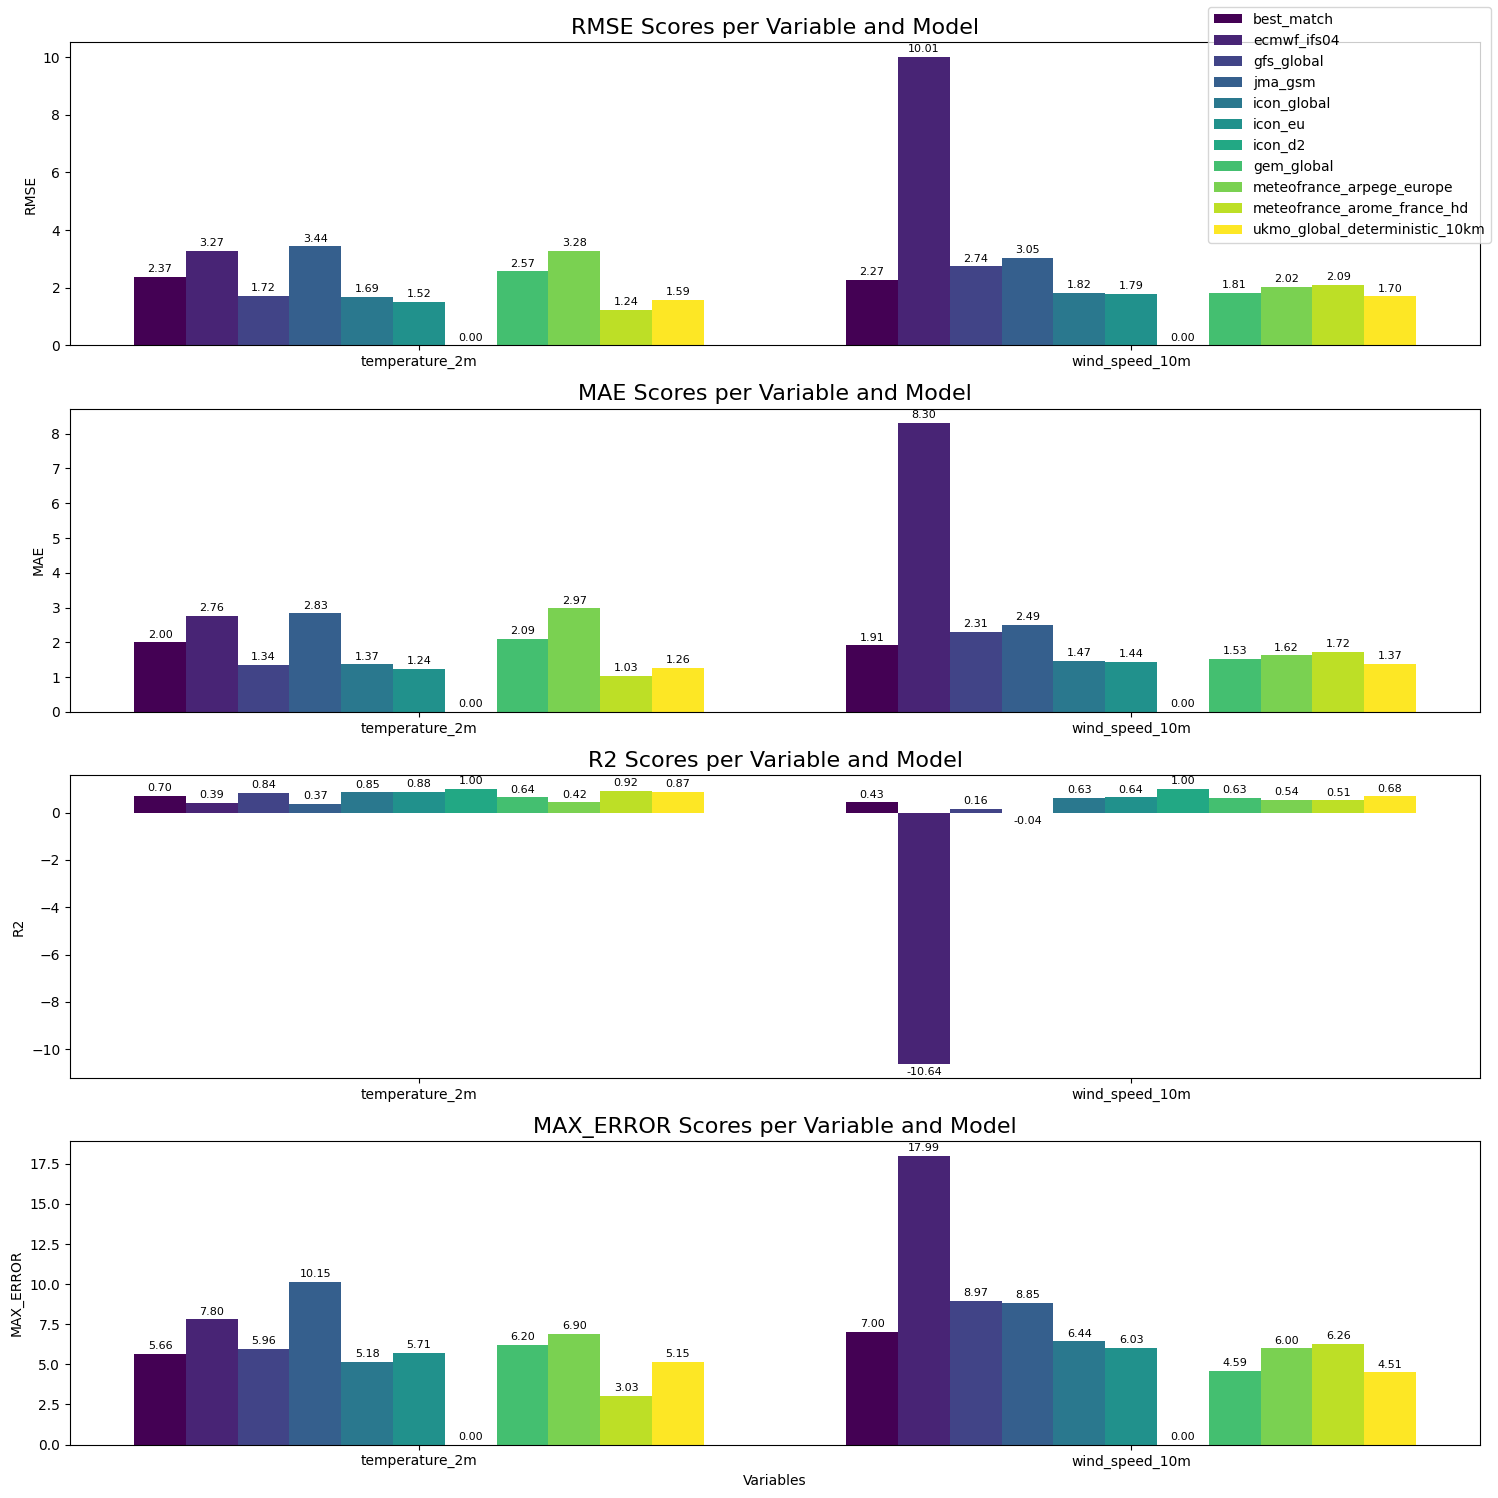

In [17]:
scores_nuevos, error_angulos_predicciones=obtener_metricas(models_hist['icon_d2'], models_pred)
graficar_metricas(scores_nuevos)


In [18]:
scores_probando_mejor=dict()
for mod in models_hist.keys():
  scores_probando_mejor[mod]=obtener_metricas(models_hist[mod], models_pred)[0]

print(scores_probando_mejor)


Model best_match
maxima direccion 360.0
minima direccion 4.085536956787109
temperature_2m: rmse: 0.0, mae: 0.0, r2: 1.0, max_error:0.0
wind_speed_10m: rmse: 0.0, mae: 0.0, r2: 1.0, max_error:0.0

Model ecmwf_ifs04
maxima direccion 282.99462890625
minima direccion 205.01686096191406
temperature_2m: rmse: 3.036987612418767, mae: 2.453257635687337, r2: 0.39504179566376485, max_error:6.691499948501587
wind_speed_10m: rmse: 9.083183901594753, mae: 7.585201090032404, r2: -22.142454930386787, max_error:15.895272731781006

Model gfs_global
maxima direccion 353.659912109375
minima direccion 2.121051788330078
temperature_2m: rmse: 2.4155509886253634, mae: 2.0227273035455835, r2: 0.637815507869817, max_error:5.75
wind_speed_10m: rmse: 2.361736051396627, mae: 1.8155156266734456, r2: 0.2946663470800053, max_error:6.663369178771973

Model jma_gsm
maxima direccion 360.0
minima direccion 9.462247848510742
temperature_2m: rmse: 1.626590330078854, mae: 1.1786818646854071, r2: 0.8357695039085515, max_er

In [19]:
# for mod in scores_probando_mejor.keys():
#   graficar_metricas(scores_probando_mejor[mod])

In [20]:
app = Dash('app1')

app.layout = html.Div([
    dcc.Dropdown(lista_modelos, lista_modelos[0], id='modelo', clearable=False),
    dcc.Graph(id='graph')
])

@app.callback(
    Output('graph', 'figure'),
    Input('modelo', 'value'))
def update_output_div(modelo):
    scores = scores_probando_mejor[modelo]
    lista_modelos_local = list(scores.keys())

    # Generar una lista de colores usando la escala "Viridis"
    if len(lista_modelos_local) > 1:
        norm = [i/(len(lista_modelos_local)-1) for i in range(len(lista_modelos_local))]
    else:
        norm = [0.5]
    color_scale = px.colors.sample_colorscale('Viridis', norm)
    model_colors_dict = dict(zip(lista_modelos_local, color_scale))

    # Definir las métricas a graficar
    metrics = ['rmse', 'mae', 'r2', 'max_error']

    # Crear figura con subplots (una fila por métrica)
    rows = len(metrics)
    fig = make_subplots(
        rows=rows, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.07,
        subplot_titles=[f'{metric.upper()} Scores per Variable and Model' for metric in metrics]
    )

    # Definir ancho de barra y función para calcular la posición (simulando el offset de grupos)
    bar_width = 0.8 / len(lista_modelos_local)
    def calculate_bar_positions(variable_index, model_index):
        group_center = variable_index
        offset = (model_index - len(lista_modelos_local) / 2 + 0.5) * bar_width
        return group_center + offset

    # Recorrer cada métrica y para cada modelo se crea una traza con las barras correspondientes a cada variable
    for metric_idx, metric in enumerate(metrics, start=1):
        for model_idx, model in enumerate(lista_modelos_local):
            x_vals = []
            y_vals = []
            # Por cada variable se calcula la posición y se extrae la puntuación
            for var_idx, variable in enumerate(atributos):
                score = scores[model][variable][metric]
                x_vals.append(calculate_bar_positions(var_idx, model_idx))
                y_vals.append(score)
            # Añadir traza de barra para la métrica actual
            fig.add_trace(
                go.Bar(
                    x=x_vals,
                    y=y_vals,
                    name=model,
                    marker_color=model_colors_dict[model],
                    width=[bar_width]*len(x_vals)
                ),
                row=metric_idx, col=1
            )
        # Configurar los ticks del eje x para que se centren en cada grupo (variable)
        fig.update_xaxes(
            tickmode='array',
            tickvals=[i for i in range(len(atributos))],
            ticktext=atributos,
            row=metric_idx, col=1
        )
        # Etiqueta para el eje y de cada subplot
        fig.update_yaxes(title_text=metric.upper(), row=metric_idx, col=1)

    # Actualizar layout general
    fig.update_layout(
        barmode='group',
        height=1200,
        width=1600,
        legend_title_text='Modelos',
        title_text="Métricas por Variable y Modelo",
        margin=dict(t=100)
    )

    return fig

if __name__ == '__main__':
    app.run(debug=True, port=8072)

<IPython.core.display.Javascript object>

In [21]:
"""Gráfica de datos para cada modelo y variable"""

app = Dash('app1')

app.layout = html.Div([

  dcc.Dropdown(lista_modelos, lista_modelos[0], id='modelo', clearable=False),
  dcc.Dropdown(atribs, atribs[0], id='atributo', clearable=False),
  dcc.Checklist(
          id='ver_error',
          options=[{'label': 'Cambiar a visualizar error', 'value': 'error'}],
          value=[]
  ),

  dcc.Graph(id='graph')
])


@app.callback(
    Output('graph', 'figure'),
    Input('modelo', 'value'),
    Input('atributo', 'value'),
    Input('ver_error', 'value'))
def update_output_div(modelo, atributo, ver_error):


  fig = go.Figure()

  # Convert models_hist to a DataFrame before merging
  datos_trabajo_model=pd.DataFrame(models_hist['icon_d2']).merge(models_pred[modelo], on="date", how="left", suffixes=("", f"_{modelo}"),)
  datos_trabajo_model.dropna(inplace=True)

  y_true=datos_trabajo_model[atributo]
  y_pred_model=datos_trabajo_model[atributo+f"_{modelo}"]

  if 'error' in ver_error:
    if atributo != 'wd_sin_10m' and atributo != 'wd_cos_10m':
      fig.add_trace(go.Scatter(y=y_true-y_pred_model, mode='lines', marker=dict(color='red'), name='Error'))
      fig.update_layout(
          title='Error historico vs prediccion',
          transition_duration=10,
          xaxis_title='tiempo (h)',
          yaxis_title=f'Error {atributo}'
      )
    else:
      fig.add_trace(go.Scatter(y=error_angulos_predicciones[modelo], mode='lines', marker=dict(color='red'), name='Error ángulo'))
      fig.update_layout(
      title='Diferencia entre ángulos',
      transition_duration=10,
      xaxis_title='tiempo (h)',
      yaxis_title=f'Error ángulos',
      yaxis=dict(range=[0, 180]) )
  else:
    fig.add_trace(go.Scatter(y=y_pred_model, mode='lines', marker=dict(color='red'), name='Predichas'))
    fig.add_trace(go.Scatter(y=y_true, mode='lines', marker=dict(color='blue'), opacity=0.5, name='Historicas'))

    fig.update_layout(
        title='Historico vs prediccion',
        transition_duration=10,
        xaxis_title='tiempo (h)',
        yaxis_title=f'{atributo}'
    )


  return fig



if __name__ == '__main__':
    app.run(debug=True, port=8073)


<IPython.core.display.Javascript object>



---


# Comparación con los datos históricos de la estación

In [22]:
reales=pd.read_csv('/content/produkt_wind_399_akt.txt', delimiter=';')
temperatura=pd.read_csv('/content/produkt_air_temperature_399_akt.txt', delimiter=';')


display(reales.head())
display(temperatura.head())

print('reales', reales.columns)
print('temperatura', temperatura.columns)


,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,STRUKTUR_VERSION,WINDGESCHWINDIGKEIT,WINDRICHTUNG,eor
0,399,2015082001,2,0,7.5,100,eor
1,399,2015082002,2,0,8.1,120,eor
2,399,2015082003,2,0,7.3,120,eor
3,399,2015082004,2,0,7.4,120,eor
4,399,2015082005,2,0,8.6,120,eor


,STATIONS_ID,MESS_DATUM,QUALITAETS_NIVEAU,STRUKTUR_VERSION,LUFTTEMPERATUR,REL_FEUCHTE,STRAHLUNGSTEMPERATUR,eor
0,399,2015082001,3,0,15.9,92,-999,eor ...
1,399,2015082002,3,0,15.2,93,-999,eor ...
2,399,2015082003,3,0,14.8,87,-999,eor ...
3,399,2015082004,3,0,14.6,70,-999,eor ...
4,399,2015082005,3,0,15.0,63,-999,eor ...


reales Index(['STATIONS_ID', ' MESS_DATUM', ' QUALITAETS_NIVEAU', ' STRUKTUR_VERSION',
       ' WINDGESCHWINDIGKEIT', ' WINDRICHTUNG', ' eor'],
      dtype='object')
temperatura Index(['STATIONS_ID', ' MESS_DATUM', ' QUALITAETS_NIVEAU', ' STRUKTUR_VERSION',
       ' LUFTTEMPERATUR', ' REL_FEUCHTE', ' STRAHLUNGSTEMPERATUR',
       ' eor                                                                                    '],
      dtype='object')


In [23]:
# Cambiar los nombres de las columnas del alemán para que sean las mismas

atribs=['temperature_2m', 'wind_speed_10m', 'wd_sin_10m', 'wd_cos_10m']
reales.rename(columns={
    'STATIONS_ID': 'id_estacion',
    ' MESS_DATUM': 'date',
    ' QUALITAETS_NIVEAU': 'nivel_calidad',
    ' STRUKTUR_VERSION': 'version_estructura',
    ' WINDGESCHWINDIGKEIT': atribs[1],
    ' WINDRICHTUNG':'wind_direction_10m',
    ' eor':'eor'}, inplace=True)



temperatura.rename(columns={
    'STATIONS_ID': 'id_estacion',
    ' MESS_DATUM': 'date',
    ' LUFTTEMPERATUR': atribs[0]}, inplace=True)



display(reales.head())
display(temperatura.head())


,id_estacion,date,nivel_calidad,version_estructura,wind_speed_10m,wind_direction_10m,eor
0,399,2015082001,2,0,7.5,100,eor
1,399,2015082002,2,0,8.1,120,eor
2,399,2015082003,2,0,7.3,120,eor
3,399,2015082004,2,0,7.4,120,eor
4,399,2015082005,2,0,8.6,120,eor


,id_estacion,date,QUALITAETS_NIVEAU,STRUKTUR_VERSION,temperature_2m,REL_FEUCHTE,STRAHLUNGSTEMPERATUR,eor
0,399,2015082001,3,0,15.9,92,-999,eor ...
1,399,2015082002,3,0,15.2,93,-999,eor ...
2,399,2015082003,3,0,14.8,87,-999,eor ...
3,399,2015082004,3,0,14.6,70,-999,eor ...
4,399,2015082005,3,0,15.0,63,-999,eor ...


In [24]:
# Cambiar el formato de la fecha
reales['date'] = pd.to_datetime(reales['date'], format='%Y%m%d%H', errors='coerce')
temperatura['date'] = pd.to_datetime(temperatura['date'], format='%Y%m%d%H', errors='coerce')
display(reales.head())
display(temperatura.head())


,id_estacion,date,nivel_calidad,version_estructura,wind_speed_10m,wind_direction_10m,eor
0,399,2015-08-20 01:00:00,2,0,7.5,100,eor
1,399,2015-08-20 02:00:00,2,0,8.1,120,eor
2,399,2015-08-20 03:00:00,2,0,7.3,120,eor
3,399,2015-08-20 04:00:00,2,0,7.4,120,eor
4,399,2015-08-20 05:00:00,2,0,8.6,120,eor


,id_estacion,date,QUALITAETS_NIVEAU,STRUKTUR_VERSION,temperature_2m,REL_FEUCHTE,STRAHLUNGSTEMPERATUR,eor
0,399,2015-08-20 01:00:00,3,0,15.9,92,-999,eor ...
1,399,2015-08-20 02:00:00,3,0,15.2,93,-999,eor ...
2,399,2015-08-20 03:00:00,3,0,14.8,87,-999,eor ...
3,399,2015-08-20 04:00:00,3,0,14.6,70,-999,eor ...
4,399,2015-08-20 05:00:00,3,0,15.0,63,-999,eor ...


In [25]:
# Borrar las filas en las que algún campo sea -999 (quito nulos)
print(reales.shape)
print(temperatura.shape)

reales = reales[reales['wind_speed_10m'] != -999]
temperatura = temperatura[temperatura['temperature_2m'] != -999]
print()

print(reales.shape)
print(temperatura.shape)
reales = reales[reales['wind_direction_10m'] != -999]
temperatura = temperatura[temperatura['temperature_2m'] != -999]
print()

print(reales.shape)
print(temperatura.shape)


(70607, 7)
(83127, 8)

(70607, 7)
(83123, 8)

(70607, 7)
(83123, 8)


In [26]:
# Tomo los datos de 2023 y 2024
reales_2023_2024 = reales[(reales['date'].dt.year >= 2023)&(reales['date'].dt.year <= 2024)]
temperatura_2023_2024 = temperatura[(temperatura['date'].dt.year >= 2023)&(temperatura['date'].dt.year <= 2024)]


display(reales_2023_2024.head())
display(reales_2023_2024.tail())

display(temperatura_2023_2024.head())
display(temperatura_2023_2024.tail())


,id_estacion,date,nivel_calidad,version_estructura,wind_speed_10m,wind_direction_10m,eor
59578,399,2023-01-01 00:00:00,2,0,19.8,230,eor
59579,399,2023-01-01 01:00:00,2,0,20.0,230,eor
59580,399,2023-01-01 02:00:00,2,0,18.5,230,eor
59581,399,2023-01-01 03:00:00,2,0,18.3,230,eor
59582,399,2023-01-01 04:00:00,2,0,19.2,230,eor


,id_estacion,date,nivel_calidad,version_estructura,wind_speed_10m,wind_direction_10m,eor
68900,399,2024-12-31 19:00:00,2,0,16.6,250,eor
68901,399,2024-12-31 20:00:00,2,0,17.7,240,eor
68902,399,2024-12-31 21:00:00,2,0,18.9,230,eor
68903,399,2024-12-31 22:00:00,2,0,19.5,240,eor
68904,399,2024-12-31 23:00:00,2,0,20.8,240,eor


,id_estacion,date,QUALITAETS_NIVEAU,STRUKTUR_VERSION,temperature_2m,REL_FEUCHTE,STRAHLUNGSTEMPERATUR,eor
64137,399,2023-01-01 00:00:00,3,0,16.0,61,-999,eor ...
64138,399,2023-01-01 01:00:00,3,0,16.0,57,-999,eor ...
64139,399,2023-01-01 02:00:00,3,0,15.6,56,-999,eor ...
64140,399,2023-01-01 03:00:00,3,0,15.6,55,-999,eor ...
64141,399,2023-01-01 04:00:00,3,0,15.6,54,-999,eor ...


,id_estacion,date,QUALITAETS_NIVEAU,STRUKTUR_VERSION,temperature_2m,REL_FEUCHTE,STRAHLUNGSTEMPERATUR,eor
81417,399,2024-12-31 19:00:00,3,0,3.1,81,-999,eor ...
81418,399,2024-12-31 20:00:00,3,0,3.2,80,-999,eor ...
81419,399,2024-12-31 21:00:00,3,0,3.0,79,-999,eor ...
81420,399,2024-12-31 22:00:00,3,0,2.9,79,-999,eor ...
81421,399,2024-12-31 23:00:00,3,0,2.7,79,-999,eor ...


In [27]:
# Merge las temperaturas y los reales
reales_2023_2024 = pd.merge(reales_2023_2024, temperatura_2023_2024[['date', 'temperature_2m']], on='date', how='inner')

display(reales_2023_2024.head())
print(reales_2023_2024['id_estacion'].unique())

,id_estacion,date,nivel_calidad,version_estructura,wind_speed_10m,wind_direction_10m,eor,temperature_2m
0,399,2023-01-01 00:00:00,2,0,19.8,230,eor,16.0
1,399,2023-01-01 01:00:00,2,0,20.0,230,eor,16.0
2,399,2023-01-01 02:00:00,2,0,18.5,230,eor,15.6
3,399,2023-01-01 03:00:00,2,0,18.3,230,eor,15.6
4,399,2023-01-01 04:00:00,2,0,19.2,230,eor,15.6


[399]


In [28]:
# Separo la dirección de viento en seno y coseno
reales_2023_2024[atribs[2]] = np.sin(reales_2023_2024['wind_direction_10m']*np.pi/180)
reales_2023_2024[atribs[3]] = np.cos(reales_2023_2024['wind_direction_10m']*np.pi/180)

display(reales_2023_2024.head())

reales_2023_2024.drop(columns=['id_estacion', 'nivel_calidad', 'version_estructura', 'eor'], inplace=True)
display(reales_2023_2024.head())

,id_estacion,date,nivel_calidad,version_estructura,wind_speed_10m,wind_direction_10m,eor,temperature_2m,wd_sin_10m,wd_cos_10m
0,399,2023-01-01 00:00:00,2,0,19.8,230,eor,16.0,-0.766044,-0.642788
1,399,2023-01-01 01:00:00,2,0,20.0,230,eor,16.0,-0.766044,-0.642788
2,399,2023-01-01 02:00:00,2,0,18.5,230,eor,15.6,-0.766044,-0.642788
3,399,2023-01-01 03:00:00,2,0,18.3,230,eor,15.6,-0.766044,-0.642788
4,399,2023-01-01 04:00:00,2,0,19.2,230,eor,15.6,-0.766044,-0.642788


,date,wind_speed_10m,wind_direction_10m,temperature_2m,wd_sin_10m,wd_cos_10m
0,2023-01-01 00:00:00,19.8,230,16.0,-0.766044,-0.642788
1,2023-01-01 01:00:00,20.0,230,16.0,-0.766044,-0.642788
2,2023-01-01 02:00:00,18.5,230,15.6,-0.766044,-0.642788
3,2023-01-01 03:00:00,18.3,230,15.6,-0.766044,-0.642788
4,2023-01-01 04:00:00,19.2,230,15.6,-0.766044,-0.642788


### Ahora comparamos con los modelos y obtenemos los errores

In [29]:
for df in models.values():
  df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M', errors='coerce').dt.tz_localize(None)


hist_df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%dT%H:%M', errors='coerce').dt.tz_localize(None)

scores_est, error_angulos_est=obtener_metricas(reales_2023_2024, models)


Model best_match
maxima direccion 360.0
minima direccion 1.4320632219314575
temperature_2m: rmse: 1.0128990672256268, mae: 0.8084394652754788, r2: 0.9782274680916837, max_error:4.304499435424805
wind_speed_10m: rmse: 3.6822308277243914, mae: 2.9350891152259173, r2: 0.44664721287702047, max_error:20.368043899536133

Model ecmwf_ifs04
maxima direccion 360.0
minima direccion 1.0416086912155151
temperature_2m: rmse: 1.5320303186901345, mae: 1.1744235962568597, r2: 0.95019059964995, max_error:7.749999618530275
wind_speed_10m: rmse: 5.114472960565012, mae: 3.976362586930354, r2: -0.06753434541925762, max_error:18.99365234375

Model gfs_global
maxima direccion 360.0
minima direccion 0.7440446615219116
temperature_2m: rmse: 1.2077825852144404, mae: 0.9277526242327114, r2: 0.9690433383872953, max_error:9.508499526977538
wind_speed_10m: rmse: 5.865501951348777, mae: 4.6254614249784245, r2: -0.40407546256618665, max_error:24.07638168334961

Model jma_gsm
maxima direccion 360.0
minima direccion 0

<ipython-input-8-ea3cd0e7aeca>:8: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



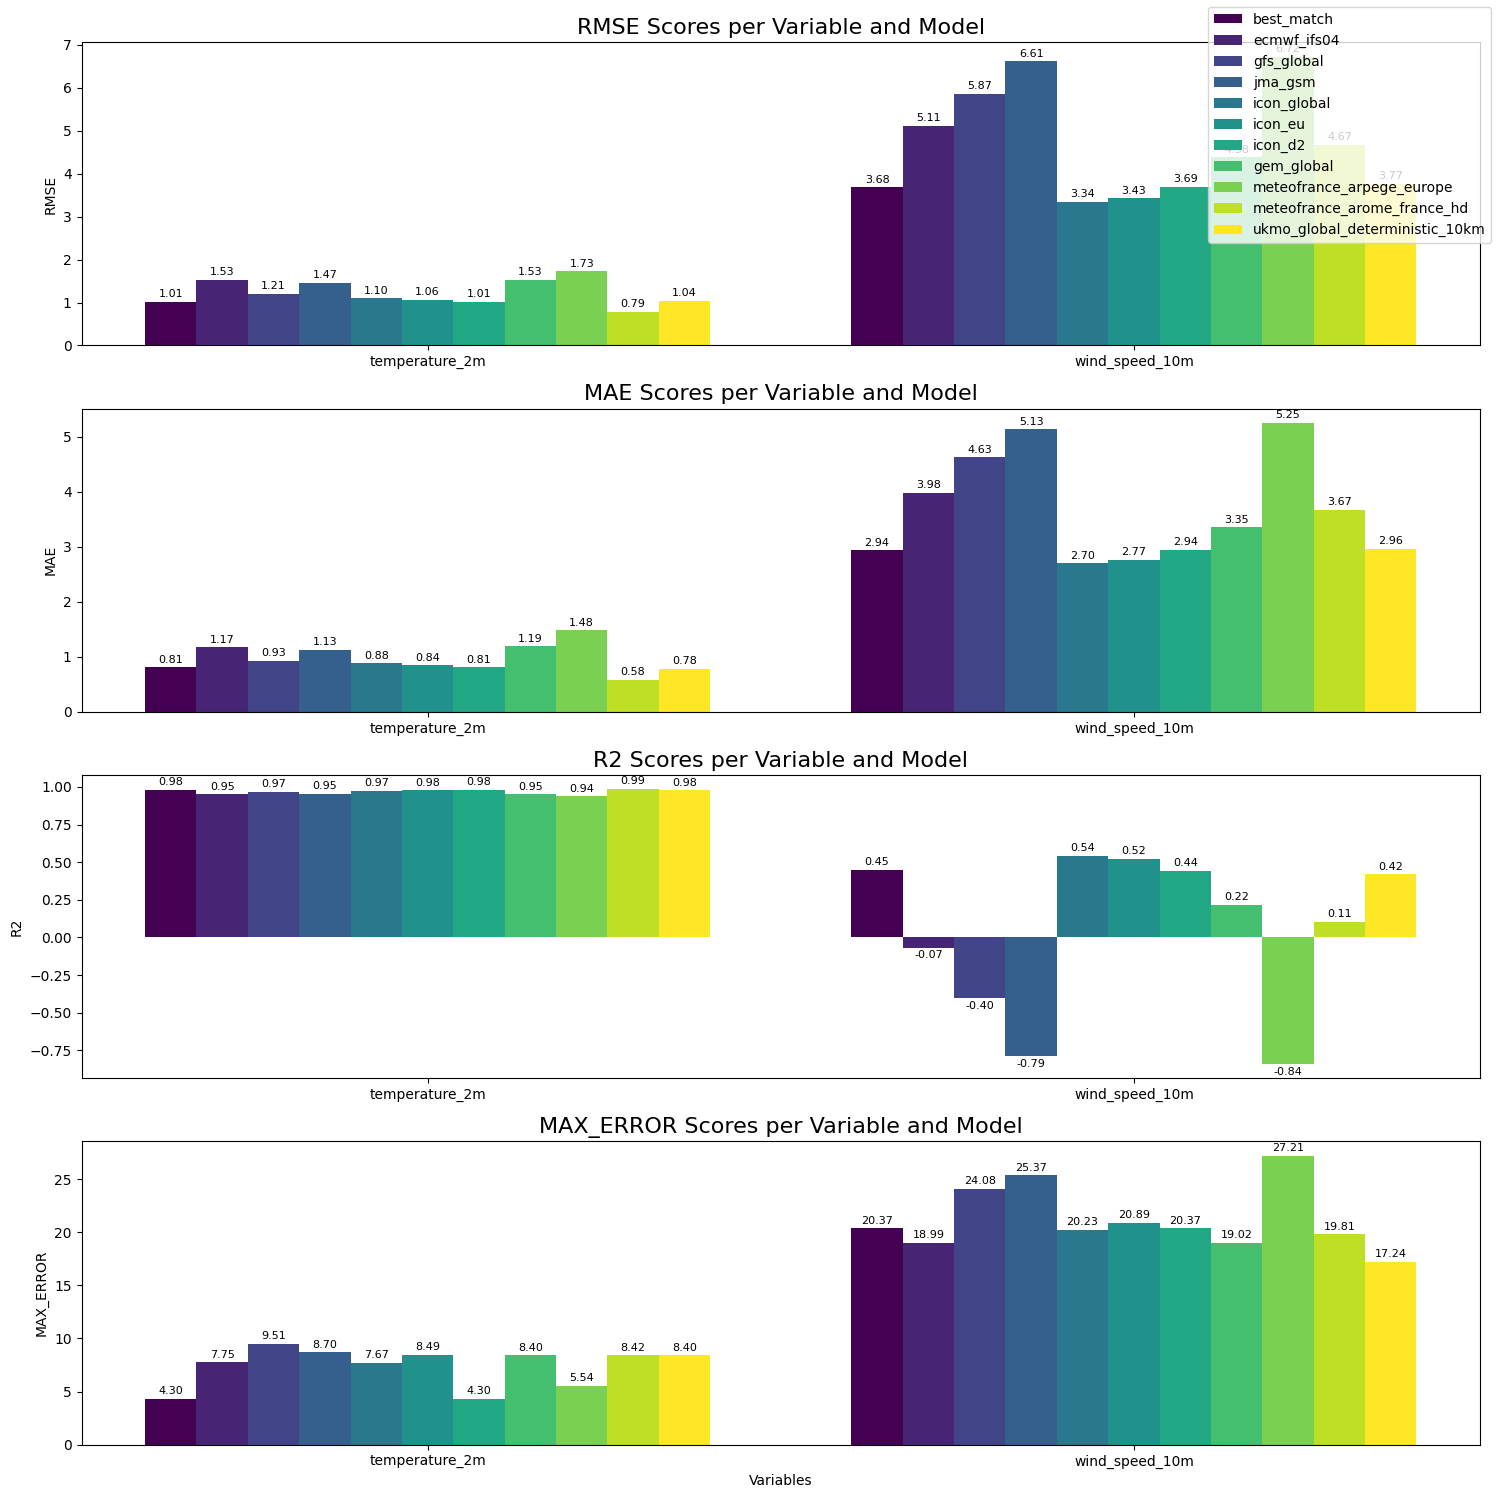

In [30]:
# Grafico las métricas
graficar_metricas(scores_est)

In [31]:
verde='\033[92m'  #Mejor con los datos de la página
rojo='\033[91m'   #Mejor con los datos de reales de la estación

for mod in models.keys():
  print(f"\n\n\n{rosa}Model {mod}{fin}")
  for atributo in atributos:
    print(f"\n{atributo}")
    for metrica in scores_est[mod][atributo]: #iteramos por los nombres de las métricas
      resta=scores[mod][atributo][metrica]-scores_est[mod][atributo][metrica]
      porcentaje=(resta/scores[mod][atributo][metrica]) if scores[mod][atributo][metrica]!=0 else 0
      if metrica != 'r2' and resta>0 or metrica == 'r2' and resta<0:
         print(f'{rojo}resta {metrica}{fin}', resta, 'porcentaje', porcentaje)
      else:
         print(f'{verde}resta {metrica}{fin}', resta, 'porcentaje', porcentaje)





Model best_match

temperature_2m
resta rmse 0.062409495281212424 porcentaje 0.05803868531997808
resta mae -0.01476183723516511 porcentaje -0.018599286049694855
resta r2 0.003658680361075084 porcentaje 0.003726175755550047
resta max_error 4.408501815795898 porcentaje 0.5059682293949241

wind_speed_10m
resta rmse 1.1498809465642323 porcentaje 0.23796654553453828
resta mae 1.1214051207665143 porcentaje 0.27644686656189954
resta r2 0.019458367452874548 porcentaje 0.04174669489925978
resta max_error -0.38435935974121094 porcentaje -0.019233658286379022



Model ecmwf_ifs04

temperature_2m
resta rmse -0.8523699167350266 porcentaje -1.2541114860937952
resta mae -0.6920778065859154 porcentaje -1.43481672568978
resta r2 0.04257291963715937 porcentaje 0.04288324340093644
resta max_error -2.608499622344972 porcentaje -0.5073421422309304

wind_speed_10m
resta rmse -2.704398619751627 porcentaje -1.1221224897315452
resta mae -2.1883198031931714 porcentaje -1.223863222455657
resta r2 0.93472083214

In [38]:
"""Gráfica de datos para cada modelo y variable"""

app = Dash('app1')

app.layout = html.Div([

  dcc.Dropdown(lista_modelos, lista_modelos[0], id='modelo', clearable=False),
  dcc.Dropdown(atribs, atribs[0], id='atributo', clearable=False),
  dcc.Checklist(
          id='ver_error',
          options=[{'label': 'Cambiar a visualizar error', 'value': 'error'}],
          value=[]
  ),
  dcc.Checklist(
          id='ver_pagina',
          options=[{'label': 'Ver los datos historicos de la pagina', 'value': 'pag'}],
          value=['pag']
  ),
  dcc.Graph(id='graph')
])


@app.callback(
    Output('graph', 'figure'),
    Input('modelo', 'value'),
    Input('atributo', 'value'),
    Input('ver_error', 'value'),
    Input('ver_pagina', 'value'))
def update_output_div(modelo, atributo, ver_error, ver_pagina):

  fig = go.Figure()

  datos_hist_2024=hist_df[(hist_df['date'].dt.year == 2024)]
  datos_hist_2024['date'] = pd.to_datetime(datos_hist_2024['date']).dt.tz_localize(None)
  datos_trabajo_model=datos_hist_2024.merge(models[modelo], on="date", how="left", suffixes=("", f"_{modelo}"),)
  datos_trabajo_model.dropna(inplace=True)

  reales_2024 = reales_2023_2024[(reales_2023_2024['date'].dt.year == 2024)]
  reales_2024['date'] = pd.to_datetime(reales_2024['date']).dt.tz_localize(None)

  datos_trabajo_est=reales_2024.merge(datos_trabajo_model, on="date", how="left", suffixes=("", f"_est"),)
  datos_trabajo_est.dropna(inplace=True)

  y_true=datos_trabajo_est[atributo]
  y_pred_model=datos_trabajo_est[atributo+f"_{modelo}"]
  y_true_est=datos_trabajo_est[atributo+f"_est"]


  if 'error' in ver_error:
    if atributo != 'wd_sin_10m' and atributo != 'wd_cos_10m':
      if 'pag' in ver_pagina:
        fig.add_trace(go.Scatter(y=y_true-y_pred_model, mode='lines', marker=dict(color='red'), name='Error pagina'))
      fig.add_trace(go.Scatter(y=y_true_est-y_pred_model, mode='lines', opacity=0.5, marker=dict(color='blue'), name='Error estación'))
      fig.update_layout(
          title='Error historico vs prediccion',
          transition_duration=10,
          xaxis_title='tiempo (h)',
          yaxis_title=f'Error{atributo}',
          showlegend=True
      )
    else:
      print(datos_trabajo_est.columns)
      dir_true=datos_trabajo_est['wind_direction_10m']
      dir_pred=datos_trabajo_est['wind_direction_10m'+f"_{modelo}"]
      dir_true_est=datos_trabajo_est['wind_direction_10m'+f"_est"]

      sin_y_true=np.sin(dir_true*np.pi/180)
      cos_y_true=np.cos(dir_true*np.pi/180)
      sin_y_pred_model=np.sin(dir_pred*np.pi/180)
      cos_y_pred_model=np.cos(dir_pred*np.pi/180)
      sin_y_true_est=np.sin(dir_true_est*np.pi/180)
      cos_y_true_est=np.cos(dir_true_est*np.pi/180)

      if 'pag' in ver_pagina:
        error_pag=[diferencia_angulos(sin_y_true[k], cos_y_true[k], sin_y_pred_model[k], cos_y_pred_model[k]) for k in range(len(y_true))]
        fig.add_trace(go.Scatter(y=error_pag, mode='lines', marker=dict(color='red'), name='Error ángulo pag'))

      error_est=[diferencia_angulos(sin_y_true_est[k], cos_y_true_est[k], sin_y_pred_model[k], cos_y_pred_model[k]) for k in range(len(y_true))]
      fig.add_trace(go.Scatter(y=error_est, mode='lines', opacity=0.5, marker=dict(color='blue'), name='Error ángulo est'))

  else:
    fig.add_trace(go.Scatter(y=y_pred_model, mode='lines', marker=dict(color='red'), name='Predichas'))
    fig.add_trace(go.Scatter(y=y_true_est, mode='lines', marker=dict(color='blue'), opacity=0.5, name='Historicas est'))

    if 'pag' in ver_pagina:
      fig.add_trace(go.Scatter(y=y_true, mode='lines', marker=dict(color='green'), opacity=0.5, name='Historicas pag'))

    fig.update_layout(
        title='Historico vs prediccion',
        transition_duration=10,
        xaxis_title='tiempo (h)',
        yaxis_title=f'{atributo}',
        showlegend=True
    )


  return fig



if __name__ == '__main__':
    app.run(debug=True, port=8074)


<IPython.core.display.Javascript object>

In [39]:
modelo='best_match'
atributo='wd_sin_10m'
ver_error=['error']
ver_pagina=['pag']

fig = go.Figure()

datos_hist_2024=hist_df[(hist_df['date'].dt.year == 2024)]
datos_hist_2024['date'] = pd.to_datetime(datos_hist_2024['date']).dt.tz_localize(None)
datos_trabajo_model=datos_hist_2024.merge(models[modelo], on="date", how="left", suffixes=("", f"_{modelo}"),)
datos_trabajo_model.dropna(inplace=True)

reales_2024 = reales_2023_2024[(reales_2023_2024['date'].dt.year == 2024)]
reales_2024['date'] = pd.to_datetime(reales_2024['date']).dt.tz_localize(None)

datos_trabajo_est=reales_2024.merge(datos_trabajo_model, on="date", how="left", suffixes=("", f"_est"),)
datos_trabajo_est.dropna(inplace=True)

y_true=datos_trabajo_est[atributo]
y_pred_model=datos_trabajo_est[atributo+f"_{modelo}"]
y_true_est=datos_trabajo_est[atributo+f"_est"]


if 'error' in ver_error:
  if atributo != 'wd_sin_10m' and atributo != 'wd_cos_10m':
    if 'pag' in ver_pagina:
      fig.add_trace(go.Scatter(y=y_true-y_pred_model, mode='lines', marker=dict(color='red'), name='Error pagina'))
    fig.add_trace(go.Scatter(y=y_true_est-y_pred_model, mode='lines', opacity=0.5, marker=dict(color='blue'), name='Error estación'))
    fig.update_layout(
        title='Error historico vs prediccion',
        transition_duration=10,
        xaxis_title='tiempo (h)',
        yaxis_title=f'Error{atributo}',
        showlegend=True
    )
  else:
    print(datos_trabajo_est.columns)
    dir_true=datos_trabajo_est['wind_direction_10m']
    dir_pred=datos_trabajo_est['wind_direction_10m'+f"_{modelo}"]
    dir_true_est=datos_trabajo_est['wind_direction_10m'+f"_est"]

    sin_y_true=np.sin(dir_true*np.pi/180)
    cos_y_true=np.cos(dir_true*np.pi/180)
    sin_y_pred_model=np.sin(dir_pred*np.pi/180)
    cos_y_pred_model=np.cos(dir_pred*np.pi/180)
    sin_y_true_est=np.sin(dir_true_est*np.pi/180)
    cos_y_true_est=np.cos(dir_true_est*np.pi/180)

    if 'pag' in ver_pagina:
      error_pag=[diferencia_angulos(sin_y_true[k], cos_y_true[k], sin_y_pred_model[k], cos_y_pred_model[k]) for k in range(len(y_true))]
      fig.add_trace(go.Scatter(y=error_pag, mode='lines', marker=dict(color='red'), name='Error ángulo pag'))

    error_est=[diferencia_angulos(sin_y_true_est[k], cos_y_true_est[k], sin_y_pred_model[k], cos_y_pred_model[k]) for k in range(len(y_true))]
    fig.add_trace(go.Scatter(y=error_est, mode='lines', opacity=0.5, marker=dict(color='blue'), name='Error ángulo est'))

else:
  fig.add_trace(go.Scatter(y=y_pred_model, mode='lines', marker=dict(color='red'), name='Predichas'))
  fig.add_trace(go.Scatter(y=y_true_est, mode='lines', marker=dict(color='blue'), opacity=0.5, name='Historicas est'))

  if 'pag' in ver_pagina:
    fig.add_trace(go.Scatter(y=y_true, mode='lines', marker=dict(color='green'), opacity=0.5, name='Historicas pag'))

  fig.update_layout(
      title='Historico vs prediccion',
      transition_duration=10,
      xaxis_title='tiempo (h)',
      yaxis_title=f'{atributo}',
      showlegend=True
  )


fig.show()


# Imprimo día y mes que no están en ambos df
faltan=pd.DataFrame()
faltan['anio']=hist_df['date'][~hist_df['date'].isin(reales_2023_2024['date'])].dt.year
faltan['mes']=hist_df['date'][~hist_df['date'].isin(reales_2023_2024['date'])].dt.month
faltan['dia']=hist_df['date'][~hist_df['date'].isin(reales_2023_2024['date'])].dt.day
faltan['hora']=hist_df['date'][~hist_df['date'].isin(reales_2023_2024['date'])].dt.hour
faltan.sort_values(by=['mes', 'dia', 'hora'], inplace=True)
print(faltan.shape)
display(faltan)

# Tomo los datos de 2023
reales_2023 = reales_2023_2024[(reales_2023_2024['date'].dt.year == 2023)]

# Quito el timezone porque da problemas en el merge
reales_2023['date'] = pd.to_datetime(reales_2023['date']).dt.tz_localize(None)
hist_df['date'] = pd.to_datetime(hist_df['date']).dt.tz_localize(None)

#Muetra los datos de febrero de reales_2023 (no hay)
display(reales_2023[reales_2023['date'].dt.month == 2])

# Tomo los datos de 2024
reales_2024 = reales_2023_2024[(reales_2023_2024['date'].dt.year == 2024)]
reales_2024['date'] = pd.to_datetime(reales_2024['date']).dt.tz_localize(None)

#Muetra los datos unicos de reales_2024
print(reales_2024['date'].dt.month.unique())
print(reales_2024[(reales_2024['date'].dt.day == 14) &( reales_2024['date'].dt.month == 12)]['date'].dt.hour.unique())

# Imprimo el número de datos que faltan para cada año para elegir cuál representar
print(faltan.groupby('anio').count())



<ipython-input-39-d764cb1f5889>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-39-d764cb1f5889>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Index(['date', 'wind_speed_10m', 'wind_direction_10m', 'temperature_2m',
       'wd_sin_10m', 'wd_cos_10m', 'temperature_2m_est', 'wind_speed_10m_est',
       'wind_direction_10m_est', 'wd_sin_10m_est', 'wd_cos_10m_est',
       'temperature_2m_best_match', 'wind_speed_10m_best_match',
       'wind_direction_10m_best_match', 'wd_sin_10m_best_match',
       'wd_cos_10m_best_match'],
      dtype='object')


(8219, 4)


,anio,mes,dia,hora
740,2023,1,31,20
741,2023,1,31,21
742,2023,1,31,22
743,2023,1,31,23
744,2023,2,1,0
...,...,...,...,...
7114,2023,10,24,10
7115,2023,10,24,11
7116,2023,10,24,12
17125,2024,12,14,13


<ipython-input-39-d764cb1f5889>:89: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,date,wind_speed_10m,wind_direction_10m,temperature_2m,wd_sin_10m,wd_cos_10m


[ 1  2  3  4  5  6  7  9 10 11 12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 17 18 19 20 21 22 23]
       mes   dia  hora
anio                  
2023  6377  6377  6377
2024  1842  1842  1842


<ipython-input-39-d764cb1f5889>:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

